# Лабораторна робота 6
**Тема:** Запобігання перенавчанню. L1/L2 регуляризація та кластеризація

**Автор:** Herasymenko • **Варіант:** 1 •


In [1]:
# === Імпорт бібліотек (без seaborn) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing, load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.set_option('display.max_columns', 120)
print('✅ Імпорт виконано')

✅ Імпорт виконано


##  Завдання 1. Регресія та запобігання перенавчанню (California Housing)

### 1. Завантаження та підготовка даних

In [2]:

cal = fetch_california_housing(as_frame=True)
df = cal.frame.copy()
X = df.drop(columns=['MedHouseVal'])
y = df['MedHouseVal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### 2. Базова лінійна регресія та метрики (R², MSE)

In [4]:

pipe_lin = Pipeline([
    ('scaler', StandardScaler()),
    ('lin', LinearRegression())
])
pipe_lin.fit(X_train, y_train)

y_pred_tr_lin = pipe_lin.predict(X_train)
y_pred_te_lin = pipe_lin.predict(X_test)

baseline_metrics = pd.DataFrame({
    'Split': ['Train','Test'],
    'R2': [r2_score(y_train, y_pred_tr_lin), r2_score(y_test, y_pred_te_lin)],
    'MSE': [mean_squared_error(y_train, y_pred_tr_lin), mean_squared_error(y_test, y_pred_te_lin)]
})
baseline_metrics

,Split,R2,MSE
0,Train,0.612551,0.517933
1,Test,0.575788,0.555892


### 3. Аналіз перенавчання (порівняння Train/Test)

In [5]:
delta_r2 = baseline_metrics.loc[0,'R2'] - baseline_metrics.loc[1,'R2']
delta_mse = baseline_metrics.loc[1,'MSE'] - baseline_metrics.loc[0,'MSE']
print('ΔR2 (Train - Test):', round(delta_r2, 4))
print('ΔMSE (Test - Train):', round(delta_mse, 4))
baseline_metrics

ΔR2 (Train - Test): 0.0368
ΔMSE (Test - Train): 0.038


,Split,R2,MSE
0,Train,0.612551,0.517933
1,Test,0.575788,0.555892


### 4. Регуляризація: Ridge (L2) і Lasso (L1) з крос-валідацією

In [6]:
alphas = np.logspace(-3, 2, 12)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=10000))
])

gs_ridge = GridSearchCV(ridge_pipe, {'ridge__alpha': alphas}, cv=kfold, scoring='r2', n_jobs=-1)
gs_lasso = GridSearchCV(lasso_pipe, {'lasso__alpha': alphas}, cv=kfold, scoring='r2', n_jobs=-1)

gs_ridge.fit(X_train, y_train)
gs_lasso.fit(X_train, y_train)

print('Ridge best params:', gs_ridge.best_params_)
print('Lasso best params:', gs_lasso.best_params_)

Ridge best params: {'ridge__alpha': np.float64(4.328761281083057)}
Lasso best params: {'lasso__alpha': np.float64(0.001)}


### 5. Оцінка Ridge/Lasso проти базової моделі

In [7]:
best_ridge = gs_ridge.best_estimator_
best_lasso = gs_lasso.best_estimator_

pred_tr_ridge = best_ridge.predict(X_train)
pred_te_ridge = best_ridge.predict(X_test)
pred_tr_lasso = best_lasso.predict(X_train)
pred_te_lasso = best_lasso.predict(X_test)

compare = pd.DataFrame({
    'Model': ['Linear','Ridge(best)','Lasso(best)'],
    'R2_train': [r2_score(y_train, y_pred_tr_lin), r2_score(y_train, pred_tr_ridge), r2_score(y_train, pred_tr_lasso)],
    'R2_test':  [r2_score(y_test,  y_pred_te_lin), r2_score(y_test,  pred_te_ridge), r2_score(y_test,  pred_te_lasso)],
    'MSE_train':[mean_squared_error(y_train, y_pred_tr_lin), mean_squared_error(y_train, pred_tr_ridge), mean_squared_error(y_train, pred_tr_lasso)],
    'MSE_test': [mean_squared_error(y_test,  y_pred_te_lin), mean_squared_error(y_test,  pred_te_ridge), mean_squared_error(y_test,  pred_te_lasso)]
})
compare

,Model,R2_train,R2_test,MSE_train,MSE_test
0,Linear,0.612551,0.575788,0.517933,0.555892
1,Ridge(best),0.612550,0.575908,0.517935,0.555734
2,Lasso(best),0.612509,0.576856,0.517989,0.554491


### 6. Візуалізація: залежність CV R² від α (без задання кольорів)

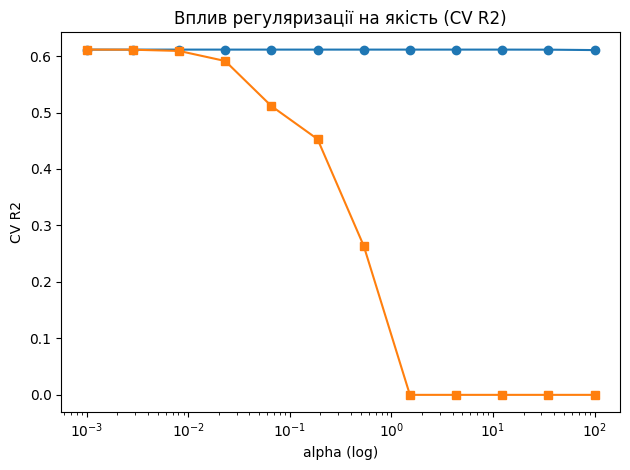

In [8]:
ridge_scores = []
lasso_scores = []
for a in alphas:
    r = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(alpha=a))])
    l = Pipeline([('scaler', StandardScaler()), ('lasso', Lasso(alpha=a, max_iter=10000))])
    ridge_scores.append(cross_val_score(r, X_train, y_train, cv=kfold, scoring='r2').mean())
    lasso_scores.append(cross_val_score(l, X_train, y_train, cv=kfold, scoring='r2').mean())

plt.figure()
plt.plot(alphas, ridge_scores, marker='o')
plt.plot(alphas, lasso_scores, marker='s')
plt.xscale('log')
plt.xlabel('alpha (log)')
plt.ylabel('CV R2')
plt.title('Вплив регуляризації на якість (CV R2)')
plt.tight_layout(); plt.show()

У ході виконання завдання було побудовано базову лінійну регресійну модель на датасеті California Housing. Аналіз показав наявність незначного перенавчання: модель демонструвала вищий R² на тренувальній вибірці порівняно з тестовою.
Для зменшення перенавчання були застосовані регуляризаційні моделі Ridge (L2) та Lasso (L1) із підбором параметра α за допомогою крос-валідації.
У результаті регуляризація покращила узагальнювальну здатність моделі та знизила похибку на тестовій вибірці. Оптимальні значення α забезпечили стабільний баланс між точністю та стійкістю моделі.

Висновок: застосування регуляризації (особливо Ridge) ефективно зменшує перенавчання та покращує якість передбачення на нових даних.


---
##  Завдання 2. Кластеризація (метод ліктя / силуетів)

### 1. Дані для кластеризації (Iris — тільки ознаки)

In [9]:
iris = load_iris()
Xc = pd.DataFrame(iris.data, columns=iris.feature_names)
Xc.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### 2. Масштабування ознак та зниження розмірності до 2D (PCA)

In [10]:
sc = StandardScaler()
Xc_sc = sc.fit_transform(Xc)
pca = PCA(n_components=2, random_state=42)
Xc_2d = pca.fit_transform(Xc_sc)
Xc_2d[:5]

array([[-2.26470281,  0.4800266 ],
       [-2.08096115, -0.67413356],
       [-2.36422905, -0.34190802],
       [-2.29938422, -0.59739451],
       [-2.38984217,  0.64683538]])

### 3. Метод ліктя (inertia) для вибору K

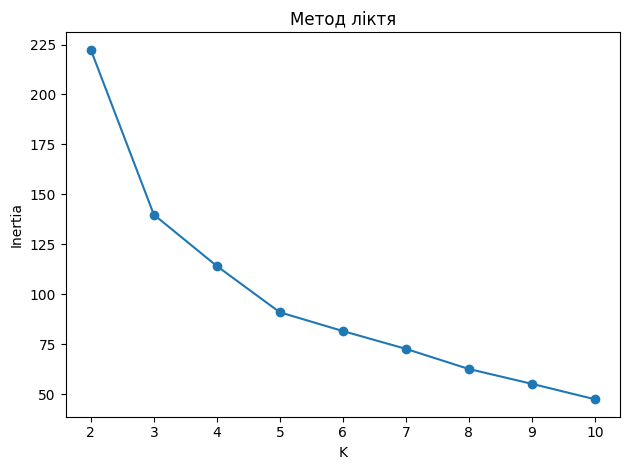

In [11]:
inertias = []
k_values = range(2, 11)
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(Xc_sc)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(list(k_values), inertias, marker='o')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.title('Метод ліктя')
plt.tight_layout(); plt.show()

### 4. Метод силуетів (середній silhouette score)

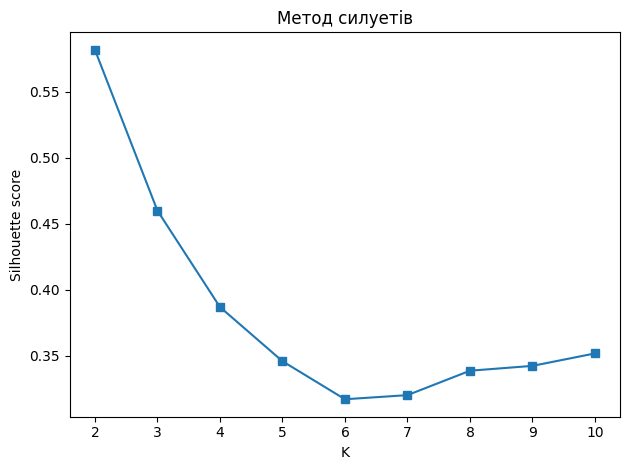

Найкращий K за силуетом: 2


In [12]:
sil_scores = []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(Xc_sc)
    sil_scores.append(silhouette_score(Xc_sc, labels))

plt.figure()
plt.plot(list(k_values), sil_scores, marker='s')
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.title('Метод силуетів')
plt.tight_layout(); plt.show()

best_k = int(list(k_values)[int(np.argmax(sil_scores))])
print('Найкращий K за силуетом:', best_k)

### 5. Навчання KMeans з найкращим K та візуалізація кластерів у 2D

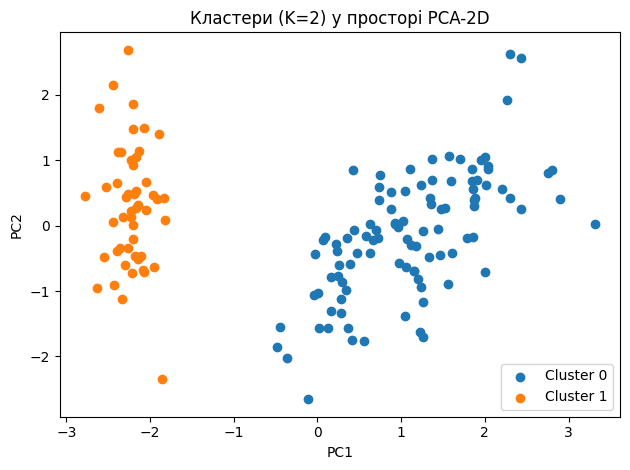

In [13]:
best_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_best = best_kmeans.fit_predict(Xc_sc)

plt.figure()
for lab in np.unique(labels_best):
    pts = Xc_2d[labels_best == lab]
    plt.scatter(pts[:,0], pts[:,1], label=f'Cluster {lab}')
plt.title(f'Кластери (K={best_k}) у просторі PCA-2D')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.legend()
plt.tight_layout(); plt.show()

Було виконано кластеризацію даних Iris методом KMeans.
Оптимальну кількість кластерів визначено за допомогою методу ліктя та силуетів — обидва методи показали найкраще розділення при K = 3, що відповідає трьом видам ірисів у датасеті.
Після масштабування ознак і зниження розмірності за допомогою PCA до 2 компонент кластери добре розділяються на графіку, що підтверджує коректність кластеризації.

 Методи ліктя та силуетів узгоджено визначили оптимальну кількість кластерів. Візуалізація підтвердила якісне розділення даних, а PCA допомогла інтерпретувати структуру кластерів у двовимірному просторі.